In [47]:
%matplotlib inline
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pymc3 as pm
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode
from warnings import filterwarnings
filterwarnings('ignore')
from utils.mnist_reader import load_mnist
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(10))

In [48]:
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.5


In [49]:
# import fashion mnist data
X_train, y_train = load_mnist('data/mnist', kind='train')
X_test, y_test = load_mnist('data/mnist', kind='t10k')
n_in = X_train.shape[1]
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# one hot encoding
#y_train = np.zeros((y_train_cat.shape[0],n_out))
#y_test = np.zeros((y_test_cat.shape[0],n_out))
#y_train[np.arange(y_train.shape[0]), y_train_cat] = 1
#y_test[np.arange(y_test.shape[0]), y_test_cat] = 1

# cast as theano float32
floatX = theano.config.floatX # does this make it a shared?

X_train = X_train.astype(floatX)/255
y_train = y_train.astype(np.int)
X_test = X_test.astype(floatX)/255
y_test = y_test.astype(np.int)

label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}
n_out = len(label_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'data/mnist/train-labels-idx1-ubyte.gz'

In [50]:
y_train[0]

9

In [28]:
n_out

10

In [29]:
X_train.shape[1]

784

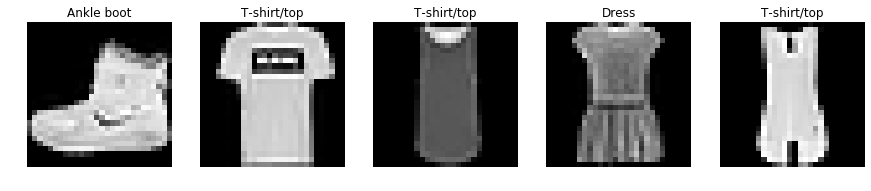

In [30]:
# show a few samples
nsamples = 5
fig = plt.figure(figsize=(15,15))
ax = fig.subplots(1,nsamples)
for i in range(nsamples):
    ax[i].imshow(np.reshape(X_train[i],(28,28)),cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(label_dict[y_train[i]])
fig.show()

In [31]:
# now create a simple 3-layer bayesian neural network in pymc3
def construct_nn(ann_input, ann_output):
    n_hidden_1 = 64
    n_hidden_2 = 32
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(n_in, n_hidden_1).astype(floatX)
    init_2 = np.random.randn(n_hidden_1, n_hidden_2).astype(floatX)
    init_out = np.random.randn(n_hidden_2,n_out).astype(floatX)

    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1.2,
                                 shape=(n_in, n_hidden_1),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1.2,
                                shape=(n_hidden_1, n_hidden_2),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1.2,
                                  shape=(n_hidden_2,n_out),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Classification
        out = pm.Categorical('out',
                           act_out,
                           observed=ann_output,
                           total_size=n_train
                          )
    return neural_network

In [32]:
minibatch_x = pm.Minibatch(X_train, batch_size=40)
minibatch_y = pm.Minibatch(y_train, batch_size=40)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(10000, method=inference)

Average Loss = 86.49: 100%|██████████| 10000/10000 [01:12<00:00, 138.19it/s]
Finished [100%]: Average Loss = 86.528


In [34]:
elbo = -inference.hist

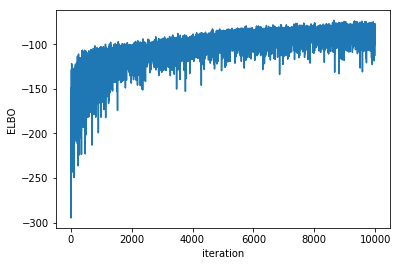

In [35]:
plt.plot(elbo)
plt.ylabel('ELBO')
plt.xlabel('iteration')
plt.show()

In [36]:
trace = approx.sample(draws=1000)

In [37]:
minibatch_x.set_value(X_test)
minibatch_y.set_value(y_test)
with neural_network_minibatch:
        ppc = pm.sample_ppc(trace, samples=100)

100%|██████████| 100/100 [00:02<00:00, 42.99it/s]


In [43]:
ppc.keys()

dict_keys(['out'])

In [38]:
y_pred = mode(ppc['out'], axis=0).mode[0,:]
y_pred

array([6, 0, 6, 4, 2, 4, 6, 6, 8, 6, 6, 4, 4, 4, 6, 4, 5, 6, 6, 6, 4, 2,
       8, 5, 4, 6, 6, 6, 4, 2, 7, 8, 4, 5, 6, 4, 2, 4, 5, 4])

In [39]:
y_test[0:49]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5,
       7, 9, 1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7,
       6, 7, 2, 1, 2])

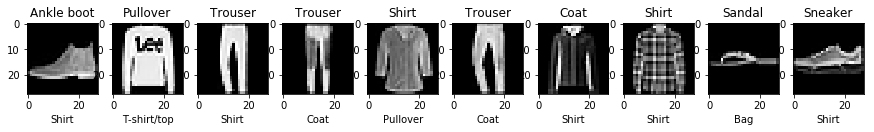

In [40]:
# show a few samples
nsamples = 10
fig = plt.figure(figsize=(15,15))
ax = fig.subplots(1,nsamples)
for i in range(nsamples):
    ax[i].imshow(np.reshape(X_test[i],(28,28)),cmap='gray')
    ax[i].set_title(label_dict[y_test[i]])
    ax[i].set_xlabel(label_dict[y_pred[i]])
fig.show()